In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import numpy as np

In [2]:
#neural data raw

img = np.load('../cnn-neuron/all_sites_data_prepared/pics_data/train_img_m1s1.npy')
resp = np.load('../cnn-neuron/all_sites_data_prepared/New_response_data/trainRsp_m1s1.npy')

img=np.reshape(img,(34000,1,50,50))
print(img.shape)
print(resp.shape)



(34000, 1, 50, 50)
(34000, 302)


In [3]:
#reshaping according to step 1 at https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c
#so one image is (1,50,50), we split into 10x10 patches, where each patch is 5x5 -> thus 100 subimages

def patchify(images, n_patches):
    n,c,h,w = images.shape
    patches = torch.zeros(n,n_patches**2, h*w//n_patches**2) #(34000, 100,25)
    patch_size = h//n_patches

    for idx,image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
                patches[idx,i*n_patches+j] = patch.flatten()
    return patches

In [6]:
img = torch.from_numpy(np.float32(img))
patch_test = patchify(img,5)
print(patch_test.shape)

torch.Size([34000, 25, 100])


In [5]:
class tang_vit(nn.Module):
    def __init__(self,chw = (1,50,50),n_patches =10):
        super(tang_vit,self).__init__()
        self.chw = chw
        self.n_patches = n_patches

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        return patches

In [6]:
class tang_vit(nn.Module):
    def __init__(self,chw = (1,50,50),n_patches =10,hidden_d=12):
        super(tang_vit,self).__init__()
        self.chw = chw
        self.n_patches = n_patches
        self.hidden_d=hidden_d

        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)

        #linear mapping of patches (could also convolve)
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d) #runnig 1:1 map from (3400,100,25) through a (25,12) mapper. so only happens on last dim

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)
        return patches

In [7]:
#now add classif token Simply put, this is a special token that we add to our model that has the role of capturing information about the other tokens.
class tang_vit(nn.Module):
    def __init__(self,chw = (1,50,50),n_patches =10,hidden_d=12):
        super(tang_vit,self).__init__()
        self.chw = chw
        self.n_patches = n_patches
        self.hidden_d=hidden_d

        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)

        #linear mapping of patches (could also convolve)
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d) #runnig 1:1 map from (3400,100,25) through a (25,12) mapper. so only happens on last dim

        #class token (learnable)
        self.class_token = nn.Parameter(torch.rand(1,self.hidden_d))
    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        #We can now add a parameter to our model and convert our (N, 49, 8) tokens tensor to an (N, 50, 8) tensor (we add the special token to each sequence).
        #added at front
        tokens = torch.stack([torch.vstack((self.class_token,tokens[i])) for i in range(len(tokens))])
        return tokens

In [8]:
def get_positional_embeddings(sequence_length,d):
    result = torch.ones(sequence_length,d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i/(10000**(j/d))) if j%2==0 else np.cos(i/(10000**((j-1)/d)))
    return result

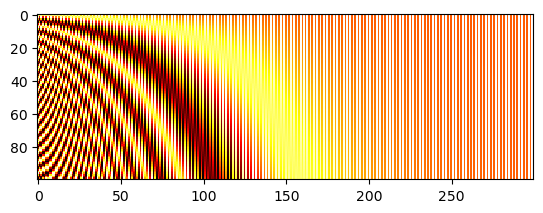

In [9]:
import matplotlib.pyplot as plt
plt.imshow(get_positional_embeddings(100,300),cmap="hot",interpolation="nearest")
plt.show()
#From the heatmap we have plotted, we see that all ‘horizontal lines’ are all different from each other, and thus samples can be distinguished.

In [10]:
#add pos encoding
class tang_vit(nn.Module):
    def __init__(self,chw = (1,50,50),n_patches =10,hidden_d=12):
        super(tang_vit,self).__init__()
        self.chw = chw
        self.n_patches = n_patches
        self.hidden_d=hidden_d

        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)

        #linear mapping of patches (could also convolve)
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d) #runnig 1:1 map from (3400,100,25) through a (25,12) mapper. so only happens on last dim

        #class token (learnable)
        self.class_token = nn.Parameter(torch.rand(1,self.hidden_d))

        #pos embed
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2+1,self.hidden_d)))
        self.pos_embed.requires_grad=False
    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        #We can now add a parameter to our model and convert our (N, 100, 12) tokens tensor to an (N, 101, 12) tensor (we add the special token to each sequence).
        #added at front
        tokens = torch.stack([torch.vstack((self.class_token,tokens[i])) for i in range(len(tokens))])

        #add pos embed
        pos_embed = self.pos_embed.repeat(n,1,1) #tokens have size (3400, 101, 12)
        out = tokens+pos_embed
        return out


We now need to implement sub-figure c of the architecture picture. What’s happening there?
Simply put: we want, for a single image, each patch to get updated based on some similarity measure with the other patches. We do so by linearly mapping each patch (that is now an 8-dimensional vector in our example) to 3 distinct vectors: q, k, and v (query, key, value).
Then, for a single patch, we are going to compute the dot product between its q vector with all of the k vectors, divide by the square root of the dimensionality of these vectors (sqrt(8)), softmax these so-called attention cues, and finally multiply each attention cue with the v vectors associated with the different k vectors and sum all up.
In this way, each patch assumes a new value that is based on its similarity (after the linear mapping to q, k, and v) with other patches. This whole procedure, however, is carried out H times on H sub-vectors of our current 8-dimensional patches, where H is the number of Heads. If you’re unfamiliar with the attention and multi-head attention mechanisms, I suggest you read this nice post by Yasuto Tamura.
Once all results are obtained, they are concatenated together. Finally, the result is passed through a linear layer (for good measure).
The intuitive idea behind attention is that it allows modeling the relationship between the inputs. What makes a ‘0’ a zero are not the individual pixel values, but how they relate to each other.


In [11]:
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

#Since our inputs will be sequences of size (N, 50, 8), and we only use 2 heads, we will at some point have an (N, 50, 2, 4) tensor, 
#use a nn.Linear(4, 4) module on it, and then come back, after concatenation, to an (N, 50, 8) tensor.

In [12]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [13]:
class tang_vit(nn.Module):
    def __init__(self,chw = (1,50,50),n_patches =10,n_blocks=2,hidden_d=12, n_heads=2):
        super(tang_vit,self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)

        
        #linear mapping of patches (could also convolve)
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d) #runnig 1:1 map from (3400,100,25) through a (25,12) mapper. so only happens on last dim

        #class token (learnable)
        self.class_token = nn.Parameter(torch.rand(1,self.hidden_d))

        #pos embed
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2+1,self.hidden_d)))
        self.pos_embed.requires_grad=False

        #transformer blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_d,n_heads) for _ in range(n_blocks)])

    def forward(self, images):
        n,c,h,w = images.shape
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        #We can now add a parameter to our model and convert our (N, 100, 12) tokens tensor to an (N, 101, 12) tensor (we add the special token to each sequence).
        #added at front
        tokens = torch.stack([torch.vstack((self.class_token,tokens[i])) for i in range(len(tokens))])

        #add pos embed
        pos_embed = self.pos_embed.repeat(n,1,1) #tokens have size (3400, 101, 12)
        out = tokens+pos_embed

        #transformer
        for block in self.blocks:
            out = block(out)
        return out

In [17]:
net = tang_vit()
x=torch.randn(3400,1,50,50)
print(net(x).shape)

/var/folders/y0/p78gsyrd5wv23ft_8q993_9r0000gn/T/ipykernel_99047/2832992761.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2+1,self.hidden_d)))


torch.Size([3400, 101, 12])


In [25]:
temp  = torch.randn(3400,101,12)
temp[:,0].shape

torch.Size([3400, 12])

so after this, they are extracting the class token, since this is being trained for mnist (10 digit classes), but our val is not class, but continous
in their case, they run a mlp softmax on the class tokens to put each pic in a class. we prob have to run nn.linear to map to 1 single value

In [38]:
class tang_vit(nn.Module):
    def __init__(self,chw = (1,50,50),n_patches =10,n_blocks=2,hidden_d=12, n_heads=2):
        super(tang_vit,self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)

        
        #linear mapping of patches (could also convolve)
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d) #runnig 1:1 map from (3400,100,25) through a (25,12) mapper. so only happens on last dim

        #class token (learnable)
        self.class_token = nn.Parameter(torch.rand(1,self.hidden_d))

        #pos embed
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2+1,self.hidden_d)))
        self.pos_embed.requires_grad=False

        #transformer blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_d,n_heads) for _ in range(n_blocks)])

        #flatten
        self.flatten = nn.Flatten()

        #linear
        self.linear = nn.Linear(101*12,1) #nn.Linear(self.hidden_d,1)

    def forward(self, images):
        n,c,h,w = images.shape
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        #We can now add a parameter to our model and convert our (N, 100, 12) tokens tensor to an (N, 101, 12) tensor (we add the special token to each sequence).
        #added at front
        tokens = torch.stack([torch.vstack((self.class_token,tokens[i])) for i in range(len(tokens))])

        #add pos embed
        pos_embed = self.pos_embed.repeat(n,1,1) #tokens have size (3400, 101, 12)
        out = tokens+pos_embed

        #transformer
        for block in self.blocks:
            out = block(out)

        # print("shape",out.shape) #should be (3400,101,12)
        # out = out[:,0] 
        # print("shape2",out.shape) #should be (3400,101,12)
        out = self.flatten(out)
        return self.linear(out)

In [33]:
net = tang_vit()
x=torch.randn(7,1,50,50)
print(net(x).shape)
#so here we have 7 input 50x50 images, each image is split into 10x10 patches (each patch is 5x5), so 100 subimages of size 25->mapped to 12, here 
# they only extract the class token which is the very 1st 12 of the 101 (shape2). we want to use everythig -> flatten last 2 dims?

torch.Size([7, 1])


/var/folders/y0/p78gsyrd5wv23ft_8q993_9r0000gn/T/ipykernel_99047/2883730666.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2+1,self.hidden_d)))


In [39]:
from torch.utils.data import Dataset,DataLoader
class ImageDataset(Dataset):
    def __init__(self, data, labels, num_neurons):
        self.data = data
        self.labels = labels
        self.num_neurons = num_neurons

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img = torch.tensor(self.data[index], dtype=torch.float)
        label = torch.tensor(self.labels[index, 0:self.num_neurons], dtype=torch.float)
        return img, label

In [60]:
numneurons = 1
dataset = ImageDataset(img,resp,numneurons)
loader = DataLoader(dataset,8,shuffle=True)
net = tang_vit()#models 1 neuron
opt = torch.optim.Adam(net.parameters(),lr=0.001)
lfunc = torch.nn.MSELoss()
vimg = np.load('../cnn-neuron/all_sites_data_prepared/pics_data/val_img_m1s1.npy')
vresp = np.load('../cnn-neuron/all_sites_data_prepared/New_response_data/valRsp_m1s1.npy')
vimg = np.reshape(vimg,(1000,1,50,50))
vdataset = ImageDataset(vimg,vresp,numneurons)
vloader = DataLoader(vdataset,8,shuffle=True)#

/var/folders/y0/p78gsyrd5wv23ft_8q993_9r0000gn/T/ipykernel_99047/2883730666.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2+1,self.hidden_d)))


In [61]:
net.load_state_dict(torch.load("./model2.pth"))

<All keys matched successfully>

In [62]:
losses = []
accs = []
for epoch in range(10):
    net.train()
    train_losses=[]
    for x,y in loader:
        l = lfunc(net(x),y)
        opt.zero_grad()
        l.backward()
        opt.step()
        train_losses.append(l.item())
    losses.append(np.mean(train_losses))
    
    print("Epoch " + str(epoch) + ": saved sucessfully.")
    torch.save(net.state_dict(), './model2.pth')
    
    val_losses=[]
    with torch.no_grad():
        net.eval()
        for x,y in vloader:
            l = lfunc(net(x),y)
            val_losses.append(l.item())
    accs.append(np.mean(val_losses))

    print("Epoch " + str(epoch) + " train loss is:" + str(losses[-1]))
    print("Epoch " + str(epoch) + " val loss is:" + str(accs[-1]))

Epoch 0: saved sucessfully.
Epoch 0 train loss is:0.011370505550965283
Epoch 0 val loss is:0.002558440195163712
Epoch 1: saved sucessfully.
Epoch 1 train loss is:0.011328626210130203
Epoch 1 val loss is:0.0025701463317964225
Epoch 2: saved sucessfully.
Epoch 2 train loss is:0.01136701699668158
Epoch 2 val loss is:0.0030552760334685443
Epoch 3: saved sucessfully.
Epoch 3 train loss is:0.01123771760216914
Epoch 3 val loss is:0.004376672444399446
Epoch 4: saved sucessfully.
Epoch 4 train loss is:0.011289848430753303
Epoch 4 val loss is:0.0043562066392041745
Epoch 5: saved sucessfully.
Epoch 5 train loss is:0.011266216082128641
Epoch 5 val loss is:0.0030372451613657177
Epoch 6: saved sucessfully.
Epoch 6 train loss is:0.011259376984500491
Epoch 6 val loss is:0.006147770416922867
Epoch 7: saved sucessfully.
Epoch 7 train loss is:0.011244428810910048
Epoch 7 val loss is:0.002738183693727478
Epoch 8: saved sucessfully.
Epoch 8 train loss is:0.011275834611918339
Epoch 8 val loss is:0.002588969

In [63]:
images = np.asarray([item[0:1] for item in vresp])
responses = torch.from_numpy(np.float32(vimg))
responses2 = net(responses).detach().numpy()
images = np.transpose(images)
responses2 = np.transpose(responses2)

In [64]:
corrs = []
for i in range(1):
    corrs.append(np.corrcoef(images[i], responses2[i])[0][1])
print(corrs)
print(np.mean(corrs))

[0.31691832544247]
0.31691832544247


result: modeled 1st neuron, 0.21 correlation ....
however, model is virtually untuned, and also the class token seems wrong...
